# Генерация данных и предсказание выгорания сотрудников IT-кампаний

## 1. Генерация сырых данных

In [1]:
# импорт библиотек для работы с таблицами и массивами
import pandas as pd
import numpy as np

# импорт библиотек для графиков
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
!pip install kaleido
import kaleido #required
kaleido.__version__ #0.2.1
import plotly
plotly.__version__ #5.5.0
# pio.templates.default = "plotly_dark"

# импорт библиотек для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics
from sklearn.svm import SVC
!pip install lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.8 MB/s eta 0:00:00


In [2]:
def create_worker(days, worker_id=0):
    # генерация дат
    tidx = pd.date_range('2022-03-11', periods=days, freq='D')
    time_data = pd.DataFrame({'date': tidx})

    # выделение дня недели и исключение суббот и воскресений
    time_data['dow'] = time_data['date'].dt.dayofweek
    time_data = time_data.query('dow != [5,6]')

    # количество рабочих дней за период
    row_count = time_data.shape[0]

    # генерация околопостоянных данных о сотруднике: таких как количество человек в команде, формат работы
    team_members = np.round(np.random.normal(8, 2)).astype(int)
    projects_amount = np.round(np.random.normal(3, 0.5)).astype(int)
    stek_amount = np.round(np.random.normal(5, 1)).astype(int)
    sport_player = np.random.randint(0, 2)
    job_format = np.random.randint(0, 2)

    # ----------------------

    # генерация более динамичных данных
    day_av_time = np.round(np.random.normal(8, 1, row_count)).astype(int)
    task_amount = np.round(np.random.normal(8, 2, row_count)).astype(int)
    ncomplited_task = np.round(np.random.normal(2, 0.5, row_count)).astype(int)
    avg_mess = np.round(np.random.normal(20, 3, row_count)).astype(int)

    # задаём долю вероятности выгораний сотрудника за период
    died_prob = np.random.uniform(0.93, 1)

    # генерируем массив с долей вероятности выше (сотрудник выгорел от 0.7 рабочих дней)
    died = np.random.choice([0, 1], size=row_count, p=[died_prob, 1 - died_prob])

    data = pd.DataFrame({'worker_id': worker_id, 'date': time_data['date'],'team_members': team_members, 'day_av_time': day_av_time,
                   'task_amount': task_amount, 'ncomplited_task': ncomplited_task, 'avg_mess': avg_mess, 'projects_amount': projects_amount,
                   'stek_amount': stek_amount, 'sport_player': sport_player, 'died': died})
    return data

In [3]:
# Создание и просмотр данных одного рабочего за 120 календарных дней
data_one_worker = create_worker(120)
data_one_worker.head()

,worker_id,date,team_members,day_av_time,task_amount,ncomplited_task,avg_mess,projects_amount,stek_amount,sport_player,died
0,0,2022-03-11,10,8,8,2,17,3,7,1,0
3,0,2022-03-14,10,8,8,3,18,3,7,1,0
4,0,2022-03-15,10,8,8,3,18,3,7,1,0
5,0,2022-03-16,10,8,2,2,22,3,7,1,0
6,0,2022-03-17,10,7,8,2,24,3,7,1,0


In [4]:
# создаём данные по отдельному работнику и объединяем в общую таблицу

data = pd.DataFrame()

# num в данном случае служит id работника
for num in range(100):
    data = data.append(create_worker(120, num))

# обновляем индексы
data = data.reset_index(drop=True)

In [5]:
# сохранение (при необходимости) данных в csv

# data.to_csv('100_workers_data.csv', index=False)

In [6]:
# основная информация о получившемся сыром датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8600 entries, 0 to 8599
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   worker_id        8600 non-null   int64         
 1   date             8600 non-null   datetime64[ns]
 2   team_members     8600 non-null   int64         
 3   day_av_time      8600 non-null   int64         
 4   task_amount      8600 non-null   int64         
 5   ncomplited_task  8600 non-null   int64         
 6   avg_mess         8600 non-null   int64         
 7   projects_amount  8600 non-null   int64         
 8   stek_amount      8600 non-null   int64         
 9   sport_player     8600 non-null   int64         
 10  died             8600 non-null   int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 739.2 KB


## 2. Описание данных

- `worker_id` - id работника 
- `date` - дата наблюдения
- `team_members` - количество сотрудников в отделе
- `day_av_time` - среднее время работы за день
- `task_amount` - количество задач к исполнению
- `ncomplited_task` - количество невыполненных задач
- `avg_mess` - среднее количество сообщений
- `projects_amount` - количество проектов, в которых задействован сотрудник
- `stek_amount` - количество it-решений, используемых сотрудником
- `sport_player` - сотрудник занимается спортом (0 - нет, 1 - да)
- `died` - наличие эмоционального выгорания (0 - нет, 1 - да)

## 3. Генерация аномалий

In [7]:
# Генерируем аномалии которые служат триггерами к выгоранию

def create_anomaly(column, anomaly_value):
    # Получаем рандомный id записи во всей таблице
    rand_id = np.random.randint(0, data.shape[0])

    # перезаписываем данные ячейки на новые (аномальные) данные
    data.loc[rand_id, column] = anomaly_value
    return rand_id

id_data = []

# data_shape = data.shape[0]

# Создаём аномалии в ncomplited_task
for num in range(1023):
    # перезаписываем значение рандомной строчки указанного столбца на указанное (новое) ->
    # -> значение и записываем id изменённой строки в массив
    id_data.append(create_anomaly('ncomplited_task', np.round(np.random.uniform(8, 1)).astype(int)))

# Создаём аномалии в team_members
for num in range(235):
    id_data.append(create_anomaly('team_members', np.random.randint(1, 2)))

# Создаём аномалии в day_av_time
for num in range(666):
    id_data.append(create_anomaly('day_av_time', np.round(np.random.uniform(13, 3)).astype(int)))

# Создаём аномалии в avg_mess
for num in range(1228):
    id_data.append(create_anomaly('avg_mess', np.round(np.random.uniform(4, 14)).astype(int)))

# Создаём аномалии в stek_amount
for num in range(183):
    id_data.append(create_anomaly('stek_amount', np.round(np.random.uniform(9, 2)).astype(int)))

# Создаём аномалии в projects_amount
for num in range(500):
    id_data.append(create_anomaly('projects_amount', np.round(np.random.uniform(5, 2)).astype(int)))

In [8]:
print('Количество изменённых в ходе аномализации строк: ', len(id_data))
data.iloc[id_data].head(2)

Количество изменённых в ходе аномализации строк:  3835


,worker_id,date,team_members,day_av_time,task_amount,ncomplited_task,avg_mess,projects_amount,stek_amount,sport_player,died
3787,44,2022-03-16,6,7,7,6,16,3,3,0,0
6033,70,2022-03-30,2,8,12,5,25,2,4,1,0


## 4. Разметка данных

In [9]:
# Отбираем условия, по которым сотрудники будут "выгорать"

# Если в команде было 2 или меньше человек и количество задач было больше 9, то выгорание
data['died'] = np.where(
   (data['team_members'] <=2) & (data['task_amount'] >= 9) , 1, data['died']
   )

# Если сотрудник работал больше 10 часов и ему было необходимо было работать с более, чем 7 технологиями, то выгорание
data['died'] = np.where(
   (data['day_av_time'] >= 10) & (data['stek_amount'] >= 7) , 1, data['died']
   )

# Если у сотрудника было много невыполненных задач и он работал более, чем 9 часов, то выгорание
data['died'] = np.where(
   (data['ncomplited_task'] >= 5) & (data['day_av_time'] >= 9) , 1, data['died']
   )

# Если сотрудник работал на более, чем 4 проектах и много смсился, то выгорание
data['died'] = np.where(
   (data['projects_amount'] >= 4) & (data['avg_mess'] >= 25) , 1, data['died']
   )

# Если сотрудников в отделе было много, часов работы мало, а невыполненных задач мало, то не выгорание
data['died'] = np.where(
   (data['team_members'] >= 7) & (data['day_av_time'] <= 6) & (data['ncomplited_task'] <= 1) , 0, data['died']
   )

# Если сотрудник не занимается спортом и много работает то выгорание
data['died'] = np.where(
   (data['sport_player'] < 1) & (data['day_av_time'] >= 11) , 0, data['died']
   )

# Если сотрудник работал больше 13 часов, то выгорание
data['died'] = np.where(
   (data['team_members'] >= 1) & (data['day_av_time'] >= 13) , 0, data['died']
   )

## 5. Анализ итоговых данных

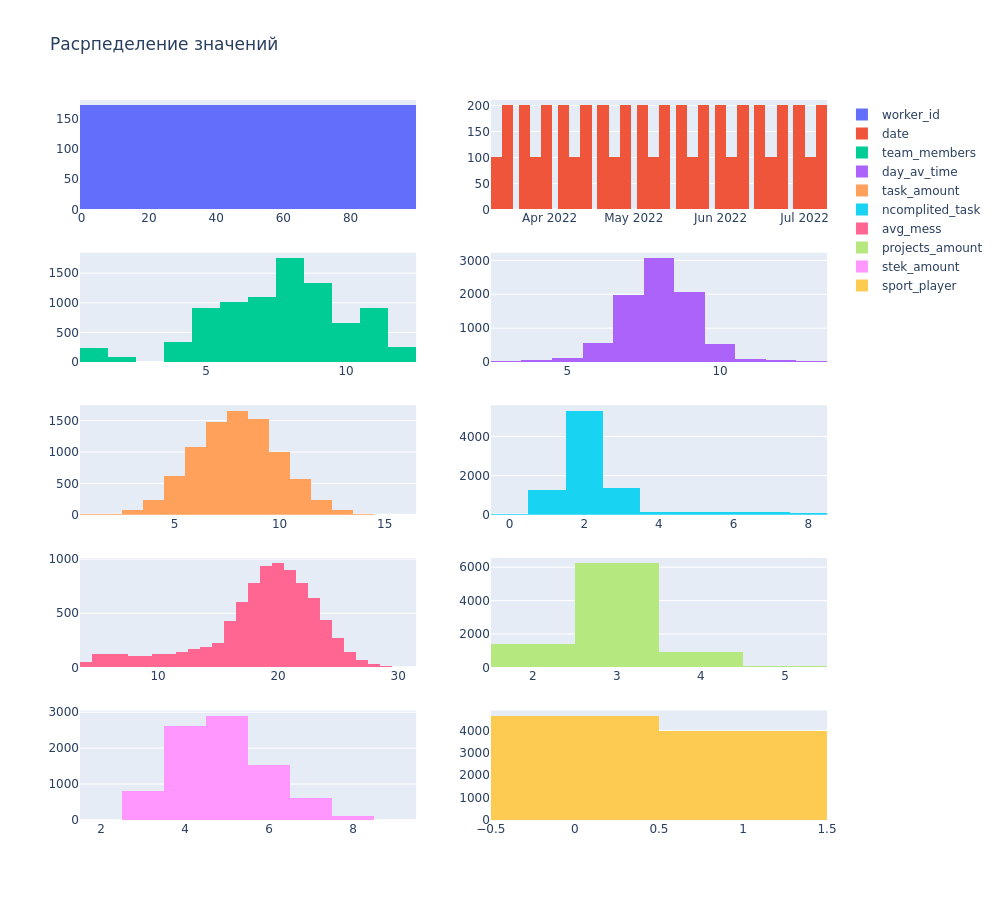

In [10]:
# Гистограммы для значений столбцов
fig = make_subplots(rows=int(len(data.columns) / 2), cols=2)

index = 0

for i in range(1, int((len(data.columns) / 2) + 1)):
    for j in range(1, 3):
        fig.add_trace(go.Histogram(x=data[data.columns[index]], name=data.columns[index], showlegend=True), row=i, col=j)
        index += 1

fig.update_layout(height=900, width=1000, title_text='Расрпеделение значений')
fig.show('png')

Большинство данных имеют нормальное распределение

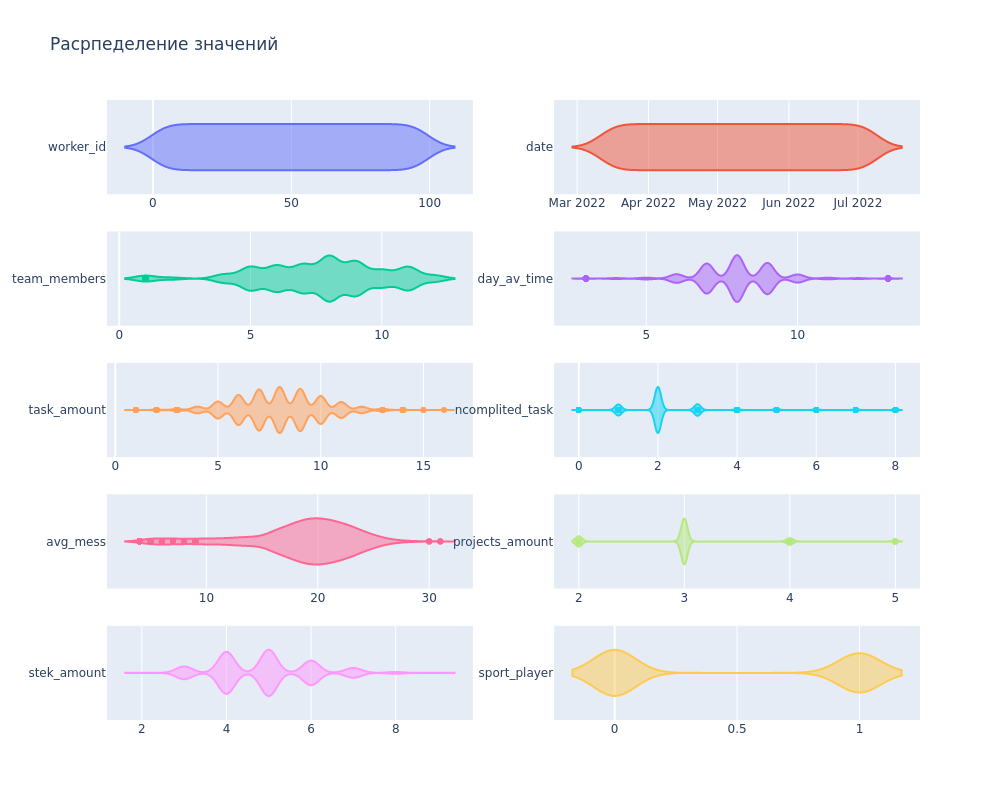

In [11]:
# Violin plots для значений столбцов
fig = make_subplots(rows=int(len(data.columns) / 2), cols=2)

index = 0

for i in range(1, int((len(data.columns) / 2) + 1)):
    for j in range(1, 3):
        fig.add_trace(go.Violin(x=data[data.columns[index]], name=data.columns[index], showlegend=False), row=i, col=j)
        index += 1
fig.update_layout(height=800, width=1000, title_text='Расрпеделение значений')
fig.show('png')

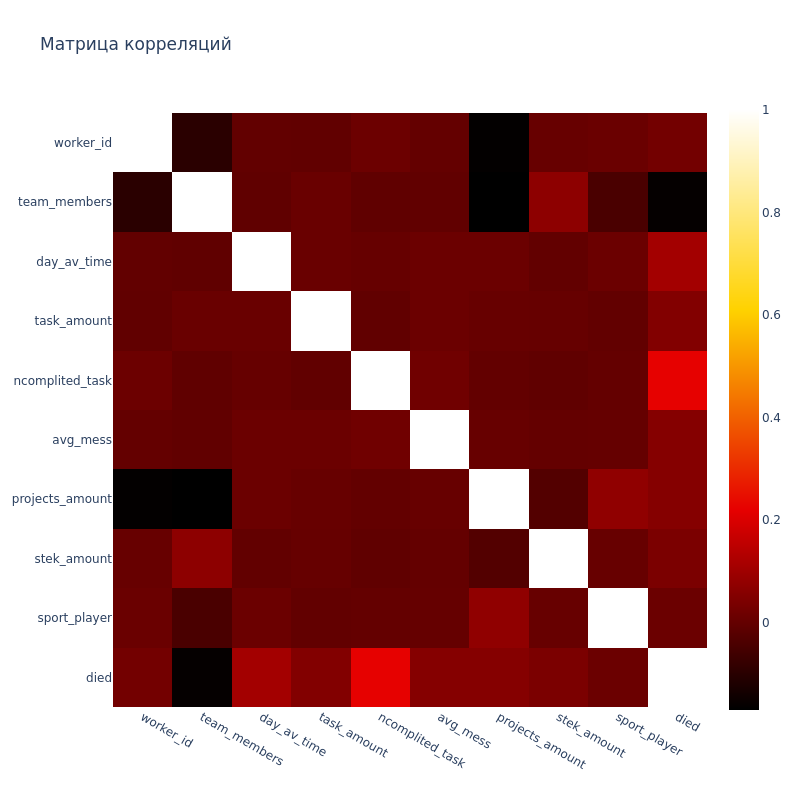

In [12]:
# построим и визуализируем корреляционную матрицу для получившихся данных
fig = px.imshow(data.corr(), color_continuous_scale='hot', title='Матрица корреляций', aspect='equal')
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show('png')

Сильная корреляция с эмоциональным выгоранием наблюдаются у количества незавершённых задач, что логично, поскольку если сотрудник не успевает в срок выполнить задачи недалеко и эмоциональное выгорание.

Также можно увидеть отрицательную корреляцию количества сотрудников в отделе с выгоранием: чем меньше сотрудников в отделе, тем больше задач приходится на одного сотрудника и, соответственно, тем выше шанс эмоционального выгорания.

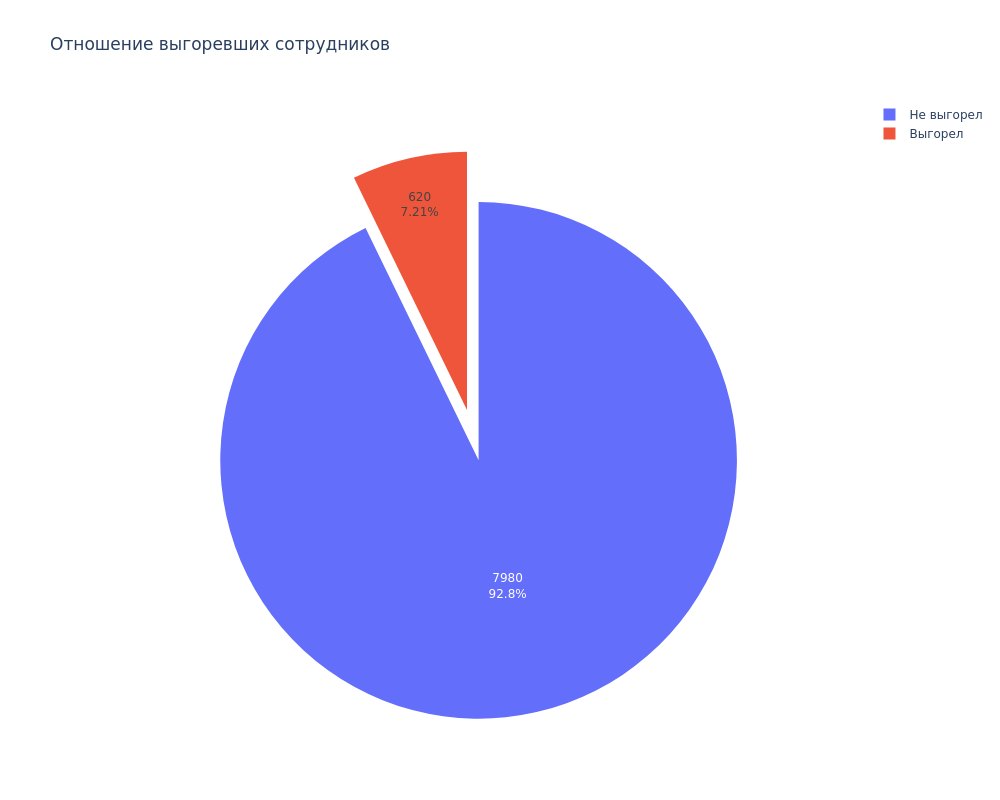

In [13]:
pie_data = data['died'].value_counts()

labels = ['Не выгорел','Выгорел']
fig = go.Figure(data=[go.Pie(labels=labels, values=pie_data, pull=[0.2, 0.0])])
fig.update_traces(textposition='inside', textinfo='percent+value')
fig.update_layout(height=800, width=1000, title_text='Отношение выгоревших сотрудников')
fig.show('png')

## 6. Обучение моделей машинного обучения (AutoML)

In [14]:
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

In [15]:
# отделяем фичи от целевого признака
x = data.drop(['died', 'worker_id', 'date'], axis=1)
y = data['died']

# разделяем данные на тестовые и валидационные в соотношении 75:25
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [16]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)
models

[21:01:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.97,0.77,0.77,0.96,0.58
RandomForestClassifier,0.97,0.77,0.77,0.96,0.50
LGBMClassifier,0.97,0.77,0.77,0.96,0.14
DecisionTreeClassifier,0.94,0.77,0.77,0.94,0.03
BaggingClassifier,0.96,0.77,0.77,0.96,0.12
ExtraTreesClassifier,0.96,0.74,0.74,0.95,0.47
SVC,0.96,0.71,0.71,0.95,0.52
NearestCentroid,0.77,0.70,0.70,0.82,0.02
QuadraticDiscriminantAnalysis,0.93,0.69,0.69,0.93,0.03


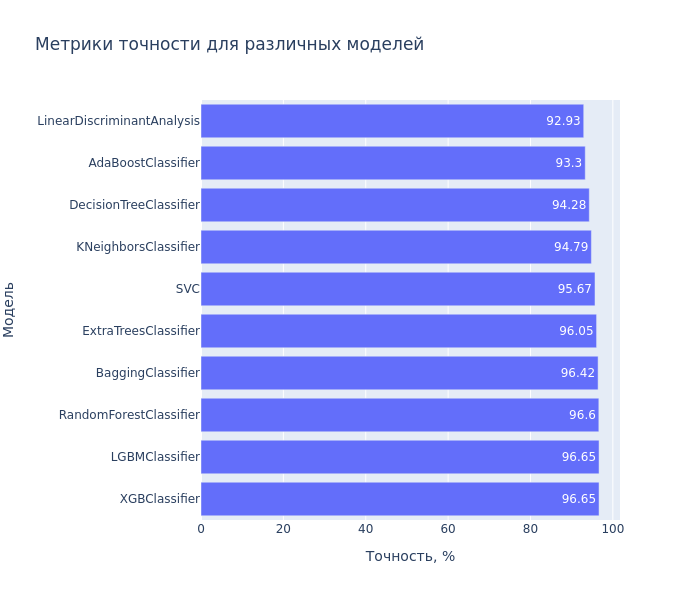

In [17]:
model_data = models.reset_index().sort_values(by='Accuracy', ascending=False).head(10)
model_data['Accuracy'] = round(model_data['Accuracy'] * 100, 2)

fig = px.bar(model_data, y='Model', x='Accuracy',
             title='Метрики точности для различных моделей', text_auto=True, height=600)
fig.update_xaxes(title='Точность, %')
fig.update_yaxes(title='Модель')
fig.show('png')

Таким образом, топ-3 моделей машинного обучения - LGBMClassifier, XGBClassifier и RandomForestClassifier

## 7. Обучение моделей машинного обучения (вручную)

Прогоним некоторые модели из списка вручную

In [18]:
# функция для отображения основных метрик моделей машинного обучения
def print_all_metrics(y_true, y_pred,  title='Metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

# функция для отображения важности каждого признака модели
def print_importances(model):
    importances = model.feature_importances_
    print('\nВажность каждого признака для модели:')
    for feature, importance in zip(x.columns, importances):
        print(f"\t{feature}: {round(importance, 2)}")

In [19]:
DecisionTree_deep = tree.DecisionTreeClassifier(random_state=1, max_depth=24)

DecisionTree_deep.fit(x_train, y_train)

lr_predictions = DecisionTree_deep.predict(x_test)

lr_predictions_proba_deep = DecisionTree_deep.predict_proba(x_test)

print_all_metrics(
    y_test,
    lr_predictions,
    'Дерево решений (глубокое)'
)

print_importances(DecisionTree_deep)

Дерево решений (глубокое)
	Accuracy: 0.94
	Precision: 0.94
	Recall: 0.56
	F1: 0.94

Важность каждого признака для модели:
	team_members: 0.17
	day_av_time: 0.23
	task_amount: 0.19
	ncomplited_task: 0.08
	avg_mess: 0.07
	projects_amount: 0.1
	stek_amount: 0.13
	sport_player: 0.03


In [20]:
svm_model = SVC(kernel="linear", probability=True).fit(x_train,y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = svm_model.predict(x_test)

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели SVC:'
)

Метрики для модели SVC:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.00
	F1: 0.89


In [21]:
XGB_model = XGBClassifier().fit(x_train,y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = XGB_model.predict(x_test)

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели XGBoost:'
)

print_importances(XGB_model)

[21:01:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Метрики для модели XGBoost:
	Accuracy: 0.97
	Precision: 0.97
	Recall: 0.55
	F1: 0.96

Важность каждого признака для модели:
	team_members: 0.12999999523162842
	day_av_time: 0.18000000715255737
	task_amount: 0.14000000059604645
	ncomplited_task: 0.12999999523162842
	avg_mess: 0.05999999865889549
	projects_amount: 0.18000000715255737
	stek_amount: 0.14000000059604645
	sport_player: 0.05000000074505806


In [22]:
LGBM_model = LGBMClassifier().fit(x_train,y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
LGBM_predictions = LGBM_model.predict(x_test)

# выведем все метрики
print_all_metrics(
    y_test,
    LGBM_predictions,
    title='Метрики для модели LGBMClassifier:'
)

Метрики для модели LGBMClassifier:
	Accuracy: 0.97
	Precision: 0.97
	Recall: 0.54
	F1: 0.96


## 8. Рассчёт вероятности эмоционального выгорания

### 8.1 Пример не выгоревшего сотрудника

Найдём вероятности отнесения сотрудника к тому или иному классу на основе новых данных.

Создадим сотрудника со следующими параметрами:

- Команда - 15 человек
- Среднее количество отработанных часов за день - 8
- Количество задач к исполнению - 6
- Количество невыполненных задач - 1
- Среднее количество сообщений - 20
- Количество проектов, в которых задействован сотрудник - 4
- Количество используемых IT-продуктов - 5
- Занимается спортом - да (1)

Должен будет получиться сотрудник, который достаточно "далёк" от эмоционального выгорания. "Новоиспеченный" сотрудник в большой команде, с малым количеством зада, занимается спортом. 

*В общем: спортсмен, комсомол и просто красавец :)*

In [23]:
good_worker = np.array([[15, 8, 6, 1, 20, 4, 5, 1]])
print('Вероятность выгорания равна:', round(XGB_model.predict_proba(good_worker)[0][1], 3))

Вероятность выгорания равна: 0.025


Как и ожидалось: вероятность выгореть минимальна

### 8.2 Пример выгоревшего сотрудника

Попробуем сгенерировать пример сотрудника, склонного к эмоциональному выгоранию:

- Команда - 2 человека
- Среднее количество отработанных часов за день - 10
- Количество задач к исполнению - 15
- Количество невыполненных задач - 7
- Среднее количество сообщений - 51 
- Количество проектов, в которых задействован сотрудник - 6
- Количество используемых IT-продуктов - 12
- Занимается спортом - нет (0)

Можно сразу предположить печальную участь данного бедолаги...

In [24]:
sad_worker = np.array([[2, 10, 15, 7, 51, 6, 12, 0]])
print('Вероятность выгорания равна:', round(XGB_model.predict_proba(sad_worker)[0][1], 3))

Вероятность выгорания равна: 1.0


Сотруднику явно приходится тяжко. Всего два человека в команде, задачи выполнять некому, так что невыполненные задачи плодяться как мухи в конюшне. Не удивительно что он не занимается спортом - некогда! 10 часов работать-то. Таким при жизни нужно памятник ставить.